In [6]:
import pandas as pd
import os
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [107]:
data = []
base = "data"
for tourn in os.listdir(base):
    for game in os.listdir(os.path.join(base, tourn)):
        df = pd.read_csv(os.path.join(base, tourn, game))
        df['gameid'] = tourn+'|'+game
        data.append(df)
#         break
    break
data = pd.concat(data)
data.to_csv("all_data.csv")

In [108]:
data.head()

,frame,p1_post_positionX,p1_post_positionY,p1_post_facingDirection,p1_post_percent,p1_post_shieldSize,p1_post_stocksRemaining,p1_post_lCancelStatus,p2_post_positionX,p2_post_positionY,p2_post_facingDirection,p2_post_percent,p2_post_shieldSize,p2_post_stocksRemaining,p2_post_lCancelStatus,stageId,winner,gameid
0,15,51.208477,27.2001,-1,0.0,60.0,4,NaN,-38.799999,27.200100,1,0.0,60.0,4,NaN,31,True,bam11|mm1-4-Game_20190519T181023.csv
1,30,43.563984,27.2001,-1,0.0,60.0,4,NaN,-38.799999,12.350101,1,0.0,60.0,4,NaN,31,True,bam11|mm1-4-Game_20190519T181023.csv
2,45,41.593983,27.2001,-1,0.0,60.0,4,NaN,-42.959999,0.000100,-1,0.0,60.0,4,NaN,31,True,bam11|mm1-4-Game_20190519T181023.csv
3,60,41.593983,27.2001,-1,0.0,60.0,4,NaN,-34.690628,0.000100,1,0.0,60.0,4,NaN,31,True,bam11|mm1-4-Game_20190519T181023.csv
4,75,41.593983,27.2001,-1,0.0,60.0,4,NaN,-12.903128,0.000100,1,0.0,60.0,4,NaN,31,True,bam11|mm1-4-Game_20190519T181023.csv


3


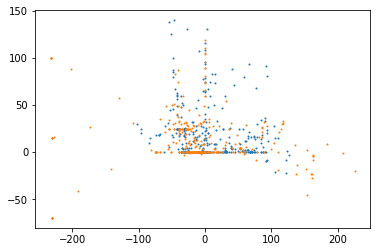

28


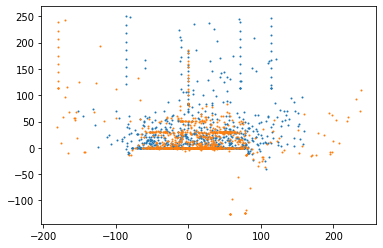

31


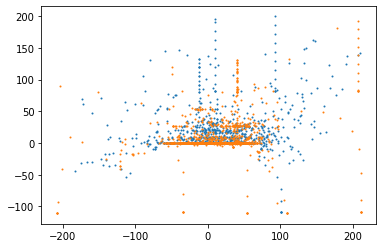

32


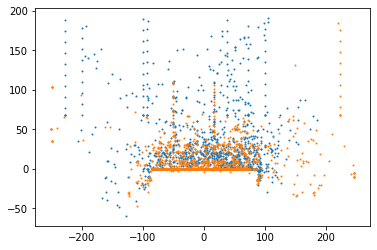

In [109]:
gp = data.groupby('stageId')
for name, g in gp:
    print(name)
    plt.scatter(g['p1_post_positionX'], g['p1_post_positionY'], s=1)
    plt.scatter(g['p2_post_positionX'], g['p2_post_positionY'], s=1)
    plt.show()

In [132]:
def get_distance_to_winlose(g):
    s1 = 4
    s2 = 4
    start = 0
    # add two new columns
    g.loc[:,'knockdown_frame'] = 0
    g.loc[:,'p1_pos_importance'] = 0
    g.loc[:,'p2_pos_importance'] = 0
    for i, row in g.iterrows():
        f = row['frame']
        # find where the stocks remaining of a player changed
        if row['p1_post_stocksRemaining'] != s1:
            end = i
            g.loc[start:end, 'knockdown_frame'] = f
            # calculate importance of frame based on the last frame
            imp = (15/(f - g[start:end]['frame']))
            # lose player get negative importance on position
            g.loc[start:end, 'p1_pos_importance'] = -imp
            g.loc[start:end, 'p2_pos_importance'] = imp
            s1 = row['p1_post_stocksRemaining']
            s2 = row['p2_post_stocksRemaining']
            start = end
        if row['p2_post_stocksRemaining'] != s2:
            end = i
            g.loc[start:end, 'knockdown_frame'] = f
            # calculate importance of frame based on the last frame
            imp = (15/(f - g[start:end]['frame']))
            g.loc[start:end, 'p1_pos_importance'] = imp
            # lose player get negative importance on position
            g.loc[start:end, 'p2_pos_importance'] = -imp
            s1 = row['p1_post_stocksRemaining']
            s2 = row['p2_post_stocksRemaining']
            start = end
            
    end = i + 1
    f += 15
    g.loc[start:end, 'knockdown_frame'] = f
    imp = (15/(f - g[start:end]['frame']))
    if row['p1_post_stocksRemaining'] > row['p2_post_stocksRemaining']:
        # p1 wins
        g.loc[start:end, 'p1_pos_importance'] = imp
        g.loc[start:end, 'p2_pos_importance'] = -imp
    elif row['p1_post_stocksRemaining'] < row['p2_post_stocksRemaining']:
        # p2 wins
        g.loc[start:end, 'p1_pos_importance'] = imp
        g.loc[start:end, 'p2_pos_importance'] = -imp
    elif row['p1_post_percent'] < row['p2_post_percent']:
        # p1 wins
        g.loc[start:end, 'p1_pos_importance'] = imp
        g.loc[start:end, 'p2_pos_importance'] = -imp
    else:
        # p2 wins
        g.loc[start:end, 'p1_pos_importance'] = imp
        g.loc[start:end, 'p2_pos_importance'] = -imp
        
    return g

gp = data.groupby('gameid').apply(get_distance_to_winlose)

In [133]:
gp[['p1_pos_importance', 'p2_pos_importance']]

,p1_pos_importance,p2_pos_importance
0,0.006024,-0.006024
1,0.006061,-0.006061
2,0.006098,-0.006098
3,0.006135,-0.006135
4,0.006173,-0.006173
...,...,...
330,0.200000,-0.200000
331,0.250000,-0.250000
332,0.333333,-0.333333
333,0.500000,-0.500000


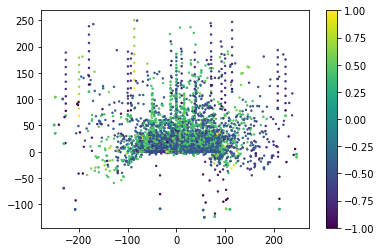

In [149]:
def scale_color(x):
    x = np.array(x)
    return np.sign(x)*np.power(np.abs(x), 1/5)
plt.scatter(gp['p1_post_positionX'], gp['p1_post_positionY'], s=2, c=scale_color(gp['p1_pos_importance']), cmap='viridis')
plt.scatter(gp['p2_post_positionX'], gp['p2_post_positionY'], s=2, c=scale_color(gp['p2_pos_importance']), cmap='viridis')
plt.colorbar()